In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.7 MB/s eta 0:00:00


In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import TensorDataset 
from torch.utils.data import random_split, DataLoader
from torchmetrics import PearsonCorrCoef, R2Score, MeanSquaredError
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)



In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, train = True, normalize = None, mean = None, std = None, transform = None, mean_str = None, std_str = None, transform_str = None,  str_dir = 'drive/MyDrive/Dataset'):
        self.str_labels = pd.read_csv(annotations_file, header=None)
        self.str_dir = str_dir
        self.train = train
        self.normalize = normalize
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mean_str = mean_str
        self.std_str = std_str
        self.transform_str = transform_str

    def __len__(self):
        return len(self.str_labels)

    def __getitem__(self, idx):
        str_path = os.path.join(self.str_dir, self.str_labels.iloc[idx, 1])
        structure = np.load(str_path)
        rand_num = np.random.rand(4)
        if self.transform:
          
          if rand_num[0] < 0.5:
            structure = np.flip(structure, axis = 1)
          if rand_num[1] < 0.5:
            structure = np.flip(structure, axis = 2)
          if rand_num[2] < 0.5:
            structure = np.flip(structure, axis = 3)
        label = float(self.str_labels.iloc[idx, 2])
        if self.normalize:
            label = (label-self.mean)/self.std
        if self.train == True and  rand_num[3] < 0.5:
            structure = np.where(structure == 0, structure, structure*-1)
        structure = torch.from_numpy(structure.copy())
        if self.transform_str:
          structure = self.transform_str(structure, self.mean_str, self.std_str)
        return structure, label

In [ ]:
data = CustomImageDataset('drive/MyDrive/Dataset/Data_files_10_clear_added.csv')

In [ ]:

test_size = 0
train_size = int(0.9 * (len(data) - test_size))
val_size = len(data) - test_size - train_size
val_size = 0
train_size = len(data)-0

train_dataset, val_dataset = random_split(data, [train_size, val_size])
#train_dataset = data

In [ ]:
print(train_size)
print(val_size)
print(test_size)

3280
0
0


In [ ]:
def transform_func_2(struct, mean, std):
  for i in range(mean.shape[0]):
    struct[i] = (struct[i] - mean[i])/std[i]
  return struct

In [ ]:
mean_str = np.array([-3.57486075e-04, -2.47384984e-04, -1.69775568e-03,  8.22317425e-04,
 -1.56263410e-04,  4.45229449e-05, -3.42080456e-04, -1.59984884e-04,
 -1.57280399e-04, -1.73632427e-04])
std_str = np.array([0.04979094, 0.04967578, 0.06257182, 0.06048465, 0.02171167, 0.02110345,
 0.05637087, 0.03777938, 0.03765806, 0.03308934])

In [ ]:
train_labels = torch.Tensor(list(data.str_labels[2][train_dataset.indices].astype(float)))
mean = torch.mean(train_labels).item()
std = torch.std(train_labels).item()
print(mean, std)

7.4862284660339355 2.1827330589294434


In [ ]:
weights = []
for i in train_labels:
  delta = abs(i-mean).item()
  if delta<=1:
    delta=1
  weights.append(delta)

In [ ]:
from torchvision import transforms
data.normalize = True
data.mean = mean
data.train = True
data.std = std
data.transform = True
data.transform_str = transform_func_2
data.mean_str = mean_str
data.std_str = std_str
data.transform_str = None

In [ ]:
val_dataset = CustomImageDataset('drive/MyDrive/Dataset/Data_files_short_clear.csv', train = False, normalize = True, transform = None, transform_str = None,  mean = mean, std = std, mean_str = mean_str, std_str = std_str, str_dir = 'drive/MyDrive/Dataset')

In [ ]:
from torch.utils.data import WeightedRandomSampler
batch_size = 32
#weightedsampler = WeightedRandomSampler(weights, len(weights)) 
one_list = [1 for i in range(len(weights))]
weightedsampler = WeightedRandomSampler(one_list, len(weights)) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = weightedsampler, num_workers=2)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=1, num_workers=2) 
#test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=2)

In [ ]:
import torch.nn as nn
import torch
from torch.nn.modules.container import Sequential

#set_random_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class First_CNN(nn.Module):

    def __init__(self):
        super().__init__()      
        self.conv_stack = nn.Sequential(
            nn.Conv3d(10, 32, 7, padding=3, bias=False), # in channel=18, out=32
            nn.MaxPool3d(2), # size [32, length/2, width/2, high/2]
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, 5, padding=2, bias=False), # in channel=32, out=64 
            nn.MaxPool3d(2), # size [64,length/2/2,width/2/2, high/2/2]
            nn.ReLU(),
            nn.BatchNorm3d(64),
            
            nn.Conv3d(64, 128, 3, padding=1, bias=False), # in channel=32, out=64 
            nn.MaxPool3d(2), # size [64,length/2/2,width/2/2, high/2/2]
            nn.ReLU(),
            nn.BatchNorm3d(128),
            #nn.Conv3d(128, 256, 3, padding=1, bias=False), # in channel=32, out=64 
            #nn.MaxPool3d(2), # size [64,length/2/2,width/2/2, high/2/2]
            #nn.ReLU(),
            #nn.BatchNorm3d(256),
            nn.Flatten(),
            nn.Linear(128*(61//2//2//2)*(61//2//2//2)*(21//2//2//2), 1000),
            nn.Dropout(0.3), 
            nn.ReLU(),
            nn.Linear(1000, 200),
            nn.Dropout(0.3),
            nn.ReLU(),
            #nn.Linear(500, 200),
            #nn.Dropout(0.3),
            #nn.ReLU(),
            nn.Linear(200, 1)   
            )

    def forward(self, x):
      x = self.conv_stack(x) 
      return x

Using device: cuda


In [ ]:
from pandas.core.dtypes.cast import maybe_box_datetimelike
from copy import deepcopy
from tqdm import tqdm

#set_random_seed(42)

def train_func(model, criterion, optimizer, num_epochs, best_metrics):
  #best_model = model
  #best_corr_coef = best_metrics
  loss_hist = [] # for plotting
  acc_val_list = []
  val_loss_hist = [] # for plotting
  for epoch in range(num_epochs):
      model.train()
      hist_loss = 0
      for _, batch in tqdm(enumerate(train_loader, 0)): # get batch
          # parse batch 
          structure, labels = batch
          structure, labels = structure.to(device=device, dtype=torch.float), labels.to(device=device, dtype=torch.float)
          # sets the gradients of all optimized tensors to zero.
          optimizer.zero_grad() 
          # get outputs
          y_pred = model(structure)
          y_pred = torch.reshape(y_pred, (-1,))
          # calculate loss
          loss = criterion(y_pred, labels)
          # calculate gradients
          loss.backward() 
          # performs a single optimization step (parameter update)
          optimizer.step()
          hist_loss += loss.item()
      loss_hist.append(hist_loss / len(train_loader))
      
      pred_list_val = []
      labels_list_val = []
      pred_list_norm = []
      labels_list_norm = []
      pearson = PearsonCorrCoef().to(device)
      model.eval()
      with torch.no_grad():
        for struct_val, labels_val in val_loader:
          struct_val, labels_val = struct_val.to(device=device, dtype=torch.float), labels_val.to(device=device, dtype=torch.float)
          #struct_val = torch.concat((struct_val[:, :9, :, :, :], struct_val[:, 10:, :, :, :]), dim=1)
          pred_val = model(struct_val.to(device))       
          labels_list_val.append(labels_val[0].item()*std+mean)
          pred_list_val.append(torch.reshape(pred_val, (-1,))[0].item()*std+mean)
          pred_list_norm.append(torch.reshape(pred_val, (-1,))[0].item())
          labels_list_norm.append(labels_val[0].item())
      val_loss_hist = criterion(torch.Tensor(pred_list_norm).to(device), torch.Tensor(labels_list_norm).to(device))
      corr_coef= pearson(torch.Tensor(pred_list_val).to(device), torch.Tensor(labels_list_val).to(device))
      if corr_coef > best_metrics:
        best_metrics = corr_coef
        best_model = deepcopy(model)
      print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f} val_loss: {round(val_loss_hist.item(),3)} val_corr: {round(corr_coef.item(),3)}")
  return best_model

In [ ]:
from lion_pytorch import Lion
set_random_seed(42)
model = First_CNN()
model.to(device)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
#optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-3)
num_epochs = 10
best_model = train_func(model, criterion, optimizer, num_epochs, 0)

103it [02:23,  1.39s/it]


Epoch=0 loss=0.9650 val_loss: 0.778 val_corr: -0.004


103it [02:24,  1.41s/it]


Epoch=1 loss=0.8585 val_loss: 0.8 val_corr: 0.094


103it [02:25,  1.42s/it]


Epoch=2 loss=0.7428 val_loss: 0.834 val_corr: -0.07


103it [02:23,  1.40s/it]


Epoch=3 loss=0.6594 val_loss: 0.722 val_corr: 0.115


103it [02:24,  1.40s/it]


Epoch=4 loss=0.6332 val_loss: 0.686 val_corr: 0.191


103it [02:24,  1.40s/it]


Epoch=5 loss=0.5642 val_loss: 0.689 val_corr: 0.214


103it [02:22,  1.39s/it]


Epoch=6 loss=0.5794 val_loss: 0.76 val_corr: 0.076


103it [02:23,  1.40s/it]


Epoch=7 loss=0.5629 val_loss: 0.642 val_corr: 0.307


103it [02:23,  1.40s/it]


Epoch=8 loss=0.5657 val_loss: 0.693 val_corr: 0.245


103it [02:22,  1.39s/it]


Epoch=9 loss=0.5275 val_loss: 0.662 val_corr: 0.31


In [ ]:
best_model.train()
optimizer = torch.optim.AdamW(best_model.parameters(), lr=0.0001, weight_decay=1e-3)
best_model2 = train_func(best_model, criterion, optimizer, 15, 0.4)

103it [02:24,  1.40s/it]


Epoch=0 loss=0.5296 val_loss: 0.666 val_corr: 0.332


103it [02:24,  1.40s/it]


Epoch=1 loss=0.5169 val_loss: 0.667 val_corr: 0.328


103it [02:25,  1.41s/it]


Epoch=2 loss=0.5368 val_loss: 0.587 val_corr: 0.427


103it [02:26,  1.42s/it]


Epoch=3 loss=0.5008 val_loss: 0.633 val_corr: 0.398


103it [02:24,  1.40s/it]


Epoch=4 loss=0.4750 val_loss: 0.605 val_corr: 0.408


103it [02:24,  1.40s/it]


Epoch=5 loss=0.4371 val_loss: 0.556 val_corr: 0.469


103it [02:23,  1.40s/it]


Epoch=6 loss=0.4614 val_loss: 0.667 val_corr: 0.449


103it [02:24,  1.41s/it]


Epoch=7 loss=0.4283 val_loss: 0.569 val_corr: 0.48


103it [02:26,  1.42s/it]


Epoch=8 loss=0.4324 val_loss: 0.555 val_corr: 0.472


103it [02:24,  1.40s/it]


Epoch=9 loss=0.4346 val_loss: 0.52 val_corr: 0.524


103it [02:24,  1.40s/it]


Epoch=10 loss=0.4094 val_loss: 0.54 val_corr: 0.513


103it [02:23,  1.40s/it]


Epoch=11 loss=0.4011 val_loss: 0.552 val_corr: 0.481


103it [02:24,  1.41s/it]


Epoch=12 loss=0.3833 val_loss: 0.542 val_corr: 0.491


103it [02:25,  1.41s/it]


Epoch=13 loss=0.3849 val_loss: 0.579 val_corr: 0.468


103it [02:25,  1.41s/it]


Epoch=14 loss=0.3892 val_loss: 0.556 val_corr: 0.463


In [ ]:
best_model2.train()
optimizer = torch.optim.AdamW(best_model2.parameters(), lr=0.00001, weight_decay=1e-3)
best_model2 = train_func(best_model2, criterion, optimizer, 15, 0.5)

103it [02:22,  1.38s/it]


Epoch=0 loss=0.3398 val_loss: 0.505 val_corr: 0.54


103it [02:22,  1.39s/it]


Epoch=1 loss=0.3513 val_loss: 0.507 val_corr: 0.534


103it [02:25,  1.41s/it]


Epoch=2 loss=0.3544 val_loss: 0.5 val_corr: 0.542


103it [02:22,  1.39s/it]


Epoch=3 loss=0.3135 val_loss: 0.507 val_corr: 0.534


103it [02:24,  1.41s/it]


Epoch=4 loss=0.3244 val_loss: 0.512 val_corr: 0.534


103it [02:26,  1.42s/it]


Epoch=5 loss=0.3362 val_loss: 0.509 val_corr: 0.532


103it [02:24,  1.40s/it]


Epoch=6 loss=0.3300 val_loss: 0.508 val_corr: 0.531


103it [02:24,  1.41s/it]


Epoch=7 loss=0.3213 val_loss: 0.516 val_corr: 0.521


103it [02:26,  1.42s/it]


Epoch=8 loss=0.3066 val_loss: 0.513 val_corr: 0.529


103it [02:25,  1.41s/it]


Epoch=9 loss=0.3208 val_loss: 0.512 val_corr: 0.525


103it [02:27,  1.43s/it]


Epoch=10 loss=0.2984 val_loss: 0.531 val_corr: 0.513


103it [02:25,  1.41s/it]


Epoch=11 loss=0.2762 val_loss: 0.529 val_corr: 0.511


103it [02:24,  1.41s/it]


Epoch=12 loss=0.3116 val_loss: 0.531 val_corr: 0.502


103it [02:24,  1.40s/it]


Epoch=13 loss=0.2889 val_loss: 0.534 val_corr: 0.504


103it [02:24,  1.40s/it]


Epoch=14 loss=0.3334 val_loss: 0.537 val_corr: 0.494


In [ ]:
import math
def validate(model, test_loader, device = "cpu"):
  model.eval()
  pred_list = []
  labels_list = []
  for struct, labels in test_loader:
      struct, labels = struct.to(device=device, dtype=torch.float), labels.to(device=device, dtype=torch.float)
      #struct = torch.concat((struct[:, :9, :, :, :], struct[:, 10:, :, :, :]), dim=1)
      pred = model(struct.to(device))     
      
      labels_list.append(labels[0].item()*std+mean)
      #labels_list.append(labels[0].item())
      pred_list.append(round(torch.reshape(pred, (-1,))[0].item()*std+mean, 2))
      #pred_list.append(round(torch.reshape(pred, (-1,))[0].item(), 2))
  pearson = PearsonCorrCoef().to(device)
  corr_coef= pearson(torch.Tensor(pred_list).to(device), torch.Tensor(labels_list).to(device))
  r2 = R2Score().to(device)
  r2_coef= r2(torch.Tensor(pred_list).to(device), torch.Tensor(labels_list).to(device))
  mse = MeanSquaredError().to(device)
  rmse = math.sqrt(mse(torch.Tensor(pred_list).to(device), torch.Tensor(labels_list).to(device)).item())
  print(f'PearsonCorr: {round(corr_coef.item(),2)}')
  print(f'RMSE: {round(rmse,3)}')
  #print(f'R2: {round(r2_coef.item(),3)}')
  return labels_list, pred_list

In [ ]:
#test_dataset = CustomImageDataset('drive/MyDrive/Dataset/Data_files_short.csv', normalize = True, transform = None, mean = mean, std = std, str_dir = 'drive/MyDrive/Dataset')

In [ ]:
#test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=2)

In [ ]:
a, b = validate(best_model2, val_loader, device=device)

PearsonCorr: 0.55
RMSE: 1.534


In [ ]:
import pandas as pd
corr_df = pd.DataFrame(columns=['Pred_pKD', 'True_pKD'])
corr_df['Pred_pKD'] = b
corr_df['True_pKD'] = a
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
corr_df

,Pred_pKD,True_pKD
0,7.23,9.16
1,6.87,8.41
2,7.26,5.00
3,6.47,6.60
4,7.05,7.48
5,8.58,9.62
6,7.77,10.33
7,6.33,5.46
8,6.69,6.37
9,8.31,7.98


In [ ]:
#corr_df.to_csv(f'drive/MyDrive/Dataset/Test_prediction.csv')

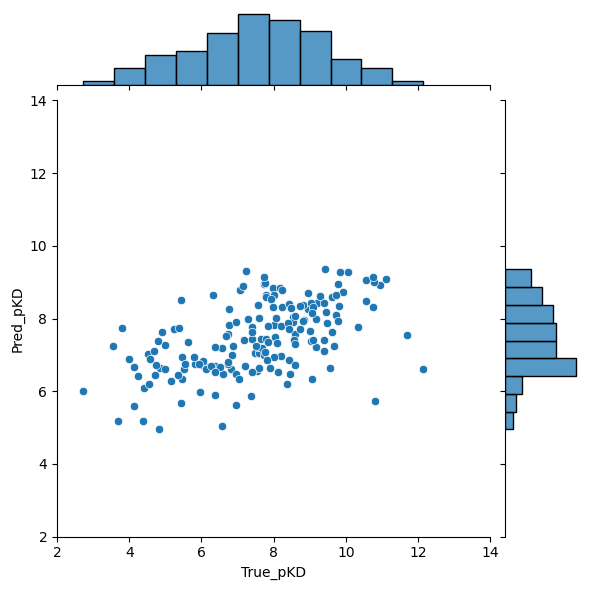

In [ ]:
import seaborn as sns
sns.jointplot(data=corr_df, x='True_pKD', y='Pred_pKD', palette='Set2', ylim=(2, 14), xlim=(2, 14))


In [ ]:
import numpy as np
params = []
sum_of_weights={el:0 for el in np.arange(10)}
i = 0
summarised_weight = 0
for param in best_model2.conv_stack[0].parameters():
    params.append(param.view(-1))
params = torch.cat(params)
params_list = params.tolist()

sum_of_weights={el:0 for el in np.arange(10)}
i = 0
summarised_weight = 0
for param in params_list:
    sum_of_weights[i%10] += param
    i += 1
sum_of_weights
# 0: Акцепторы вс 1 белка + доноры 2 белка
# 1: Акцепторы вс 2 белка + доноры 1 белка
# 2: Акцепторы вс 1 белка + слабые доноры 2 белка
# 3: Акцепторы вс 2 белка + слабые доноры 1 белка
# 4: пол. заряженные атомы 1 белка + нег. заряженные атомы 2 белка
# 5: пол. заряженные атомы 2 белка + нег. заряженные атомы 1 белка
# 6: Гидрофобные атомы 1 белка + гидрофобные атомы 2 белка
# 7: Карбоксильные кислороды 1 белка + Карбоксильные кислороды 2 белка
# 8: Карбоксильные углероды 1 белка + Карбоксильные углероды 2 белка
# 9: Ароматические атомы 1 белка + ароматические атомы 2 белка

{0: 1.1656347695620752,
 1: 0.2952499957813757,
 2: 0.08289057440708802,
 3: -1.21824255636011,
 4: 0.48452689535736226,
 5: 1.2399541571388113,
 6: 0.43974171686659247,
 7: 1.0073162300003489,
 8: 1.9560435836083343,
 9: 0.09615690773637198}

In [ ]:
torch.save(best_model2, 'drive/MyDrive/Model/model_best_55_weight_mol_dyn.pt')

In [ ]:
model1 = torch.load('drive/MyDrive/Model/model_54_new.pt')

In [ ]:
#test_data = CustomImageDataset('drive/MyDrive/Dataset_frames/Data_files_short_clear.csv', train = False, normalize = True, transform = None, mean = mean, std = std, str_dir = 'drive/MyDrive/Dataset_frames')
#test_loader = DataLoader(test_data, shuffle=False, batch_size=1, num_workers=2)
#model1 = torch.load('drive/MyDrive/Model/model_442.pt').to(device)
a, b = validate(model1, val_loader, device=device)

PearsonCorr: 0.54
RMSE: 1.593


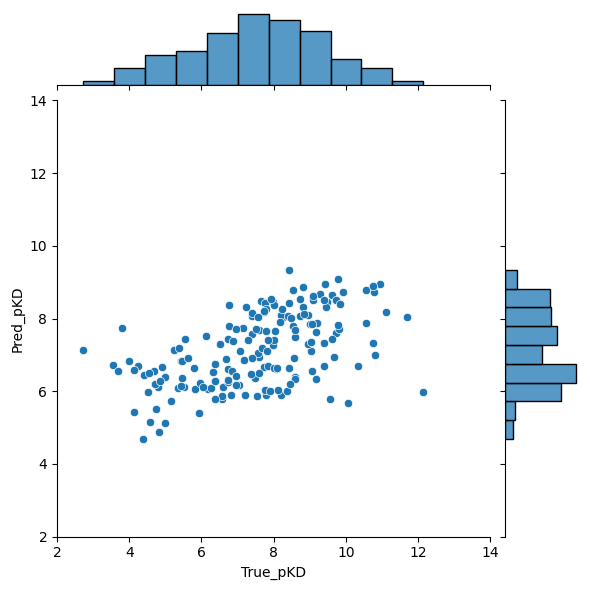

In [ ]:
import seaborn as sns
import pandas as pd
corr_df = pd.DataFrame(columns=['Pred_pKD', 'True_pKD'])
corr_df['Pred_pKD'] = b
corr_df['True_pKD'] = a
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sns.jointplot(data=corr_df, x='True_pKD', y='Pred_pKD', palette='Set2', ylim=(2, 14), xlim=(2, 14))
plt.show()

Text(0.5, 1.0, 'Predictions for 1a22 (True pKD = 9.47)')

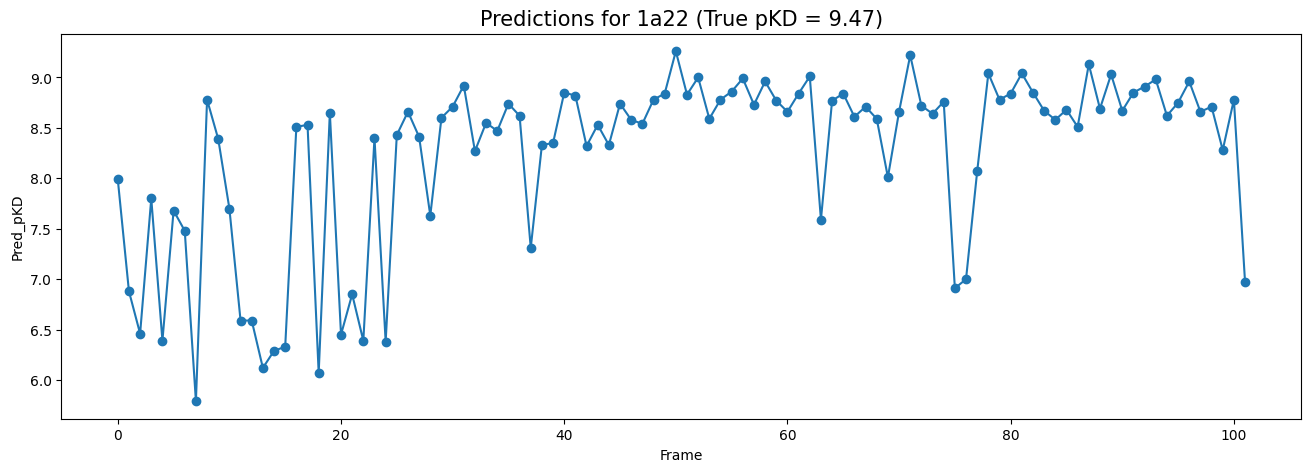

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

ax.scatter(np.arange(102), corr_df['Pred_pKD'])
ax.plot(np.arange(102), corr_df['Pred_pKD'])
plt.xlabel('Frame')
plt.ylabel('Pred_pKD')
plt.title("Predictions for 1a22 (True pKD = 9.47)", fontsize=15)


In [ ]:
# Список каналов
# 0) Атомы одного белка
# 1) Атомы другого белка
# 2) Азоты в аминогруппах
# 3) Азоты в радикале лизина и аргинина
# 4) Азоты в циклах
# 5) Углероды в линейных СН группах
# 6) Углероды в циклических соединениях
# 7) Углероды с двойной связью
# 8) Кислороды из карбокси-групп
# 9) Кислороды из ОН групп
# 10) Сера
# 11) Частичный заряд атомов
# 12) Значение гидрофобности ак
# 13) Все гетероатомы
# 14) Атомы акцепторы водородных связей
# 15) Атомы доноры водородных связей
# 16) Гетероциклические ак
# 17) Ароматические ак 
sum_of_weights

{0: 0.5009743716836965,
 1: -0.6052427329268539,
 2: -0.2928337553748861,
 3: -0.680614018401684,
 4: -1.246699742081546,
 5: 0.7770310629894084,
 6: -0.6404812503897119,
 7: -0.6328838202025509,
 8: 0.7782871652016183,
 9: 0.22523488571459893,
 10: -1.0374939107932732,
 11: 0.562511299707694,
 12: 0.6523702064041572,
 13: 0.8641577986854827,
 14: -0.9810049088737287,
 15: 0.7252463758268277,
 16: 0.6685838769153634,
 17: -0.9533219629702216}

In [ ]:
! pip install shap

In [ ]:
import shap
e = shap.DeepExplainer(
        model1, 
        test200_data]
        ).to(DEVICE))

shap.summary_plot(shap_values, features=x_samples, feature_names=features)